In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import trompy as tp

from scipy import stats
from scipy.optimize import curve_fit

import dill

rcParams['font.family'] = 'Arial'
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.transparent'] = True
colors = ["#67AFD2", "#016895", "#F4795B", "#C74632"]
custom_cmap = LinearSegmentedColormap.from_list("custom_diverging", [colors[1], "white", colors[3]])

savefigs = True

DATAFOLDER = Path("..//data")
RESULTSFOLDER = Path("..//results")
FIGSFOLDER = Path("C:/Users/jmc010/Dropbox/Publications in Progress/Bazzino Roitman_sodium/figs")

In [2]:
with open(DATAFOLDER / "bazzino_data_for_frejus.pickle", "rb") as f:
    data = dill.load(f)

x_array = data["x_array"]
snips_photo = data["snips_photo"]
snips_vel = data["snips_vel"]

In [3]:
# commented out because loading in auc from frejus file but need to make sure
# that different onset doesn't change anything too much - or can adjust AUC
# calculation

# onset = 70

# auc_snips = snips_photo[:, onset:150].mean(axis=1)
# auc_vel = snips_vel[:, onset:150].mean(axis=1)
# auc_vel.shape, auc_snips.shape

# df = pd.DataFrame({"auc_snips": auc_snips, "auc_vel": auc_vel}).dropna(axis='rows')
# x_array = pd.concat([x_array, df], axis=1)

id: PB26, params: [ 1.21832661 24.58452062 -0.81505934 -0.32850124]
id: PB26, params: [ 5.85033703 25.04740663  0.29231567 -3.11147936]
id: PB27, params: [  0.23080997  26.11179732 -29.11874848  -0.14179697]
id: PB27, params: [-33.61841484 -10.41869177   6.70542354  35.49782611]
id: PB30, params: [ 1.36284032  3.1119352  -0.30142632  0.12946418]
id: PB30, params: [-4.82051874 25.8624721  -0.3217354   1.21402908]
id: PB31, params: [ 1.09606014 24.53501528 -1.08151564 -0.44150336]
id: PB31, params: [ 4.81106677 21.64859582  4.12196646 -2.87542746]
id: PB46, params: [ 7.84934877e+03 -6.73633403e+01 -1.31327459e-01  1.61634341e-01]
id: PB46, params: [ 1.20745551 23.54269851 15.52660483  0.58187623]
id: PB48, params: [ 1.66117938e+02  2.04192636e+02 -3.70562255e-02 -1.65969616e+02]
id: PB48, params: [ 4.15406214 22.9811269  21.1210073  -1.34475831]
id: PB71, params: [ 1.33815296e+00  1.29908505e+01 -2.51410596e+01  9.58129215e-03]
id: PB71, params: [ 3.95658379  6.84349724  1.30481704 -3.80

C:\Users\jmc010\AppData\Local\Temp\ipykernel_6420\249628602.py:54: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(sigmoid, x, y, p0=[max(y), np.median(x), 1, min(y)], maxfev=10000)
C:\Users\jmc010\AppData\Local\Temp\ipykernel_6420\249628602.py:10: RuntimeWarning: overflow encountered in exp
  return L / (1 + np.exp(-k * (x - x0))) + b
C:\Users\jmc010\AppData\Local\Temp\ipykernel_6420\249628602.py:10: RuntimeWarning: overflow encountered in exp
  return L / (1 + np.exp(-k * (x - x0))) + b
C:\Users\jmc010\AppData\Local\Temp\ipykernel_6420\249628602.py:54: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(sigmoid, x, y, p0=[max(y), np.median(x), 1, min(y)], maxfev=10000)


id: PB75, params: [ 1.08725277 37.28170812 -0.06386576 -0.66705854]
id: PB75, params: [-4.9777514  27.52143796 -0.12182681  3.34031224]


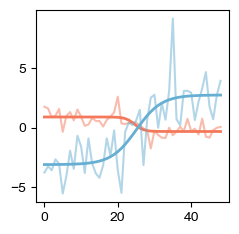

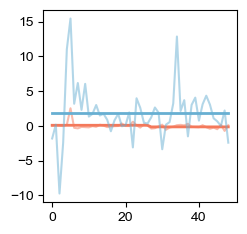

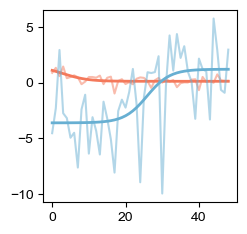

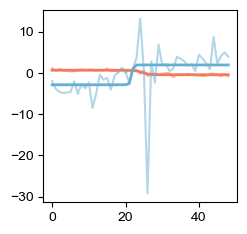

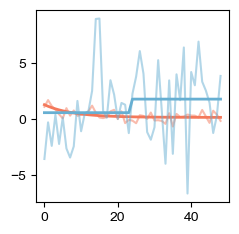

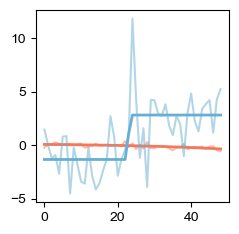

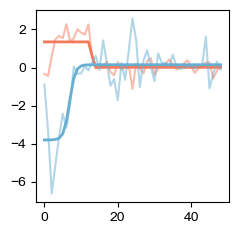

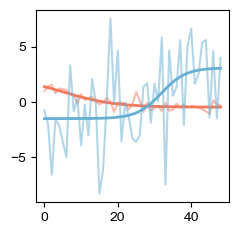

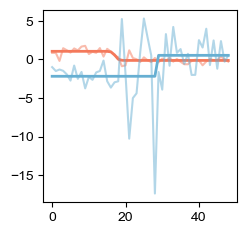

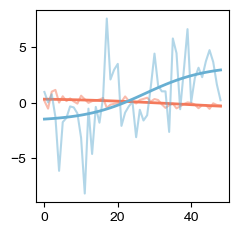

In [4]:
# Define a sigmoidal function (logistic function)
def sigmoid(x, L, x0, k, b):
    """
    Sigmoid function.
    L: Maximum value of the curve
    x0: Midpoint of the sigmoid
    k: Steepness of the curve
    b: Baseline offset
    """
    return L / (1 + np.exp(-k * (x - x0))) + b

df2_dep_45 = x_array.query("condition == 'deplete' & infusiontype == '45NaCl'").reset_index(drop=True)

snips_x0, snips_k, snips_r, vel_x0, vel_k, vel_r = [], [], [], [], [], []

for id in df2_dep_45.id.unique():

    tmp = df2_dep_45.query("id == @id")
    f, ax = plt.subplots(figsize=(2.5, 2.5))

    x = tmp.trial.values
    y = tmp.auc_snips.values # can change for tmp.auc_snips.values to fit dopamine signals

    ax.plot(x, y, color=colors[2], alpha=0.5)

    # Fit the sigmoid function to the data
    try:
        popt, pcov = curve_fit(sigmoid, x, y, p0=[max(y), np.median(x), -1, min(y)], maxfev=10000)
        y_fit = sigmoid(x, *popt)
        ax.plot(x, y_fit, color=colors[2], lw=2)
        
        print(f"id: {id}, params: {popt}")
        snips_x0.append(popt[1])  # x0 is the second parameter in popt
        snips_k.append(popt[2])  # k is the third parameter in popt

        y_fit = sigmoid(x, *popt)
        ss_res = np.sum((y - y_fit) ** 2)
        ss_tot = np.sum((y - np.mean(y)) ** 2)
        r_squared = 1 - (ss_res / ss_tot)
        snips_r.append(r_squared)

    except RuntimeError as e:
        print(f"Could not fit sigmoid for id {id}: {e}")
        snips_x0.append(np.nan)  # Append NaN if fitting fails
        snips_k.append(np.nan)
        snips_r.append(np.nan)

    y = tmp.auc_vel.values # can change for tmp.auc_snips.values to fit dopamine signals

    ax.plot(x, y, color=colors[0], alpha=0.5)

    # Fit the sigmoid function to the data
    try:
        popt, pcov = curve_fit(sigmoid, x, y, p0=[max(y), np.median(x), 1, min(y)], maxfev=10000)
        y_fit = sigmoid(x, *popt)
        ax.plot(x, y_fit, color=colors[0], lw=2)
        
        print(f"id: {id}, params: {popt}")
        vel_x0.append(popt[1])  # x0 is the second parameter in popt
        vel_k.append(popt[2])  # k is the third parameter in popt
        
        y_fit = sigmoid(x, *popt)
        ss_res = np.sum((y - y_fit) ** 2)
        ss_tot = np.sum((y - np.mean(y)) ** 2)
        r_squared = 1 - (ss_res / ss_tot)
        vel_r.append(r_squared)

    except RuntimeError as e:
        print(f"Could not fit sigmoid for id {id}: {e}")
        vel_x0.append(np.nan)  # Append NaN if fitting fails
        vel_k.append(np.nan)
        vel_r.append(np.nan)
        
snips_x0 = np.array(snips_x0)
snips_k = np.array(snips_k)
vel_x0 = np.array(vel_x0)
vel_k = np.array(vel_k)


In [126]:
df_fitted_params = pd.DataFrame({"id": df2_dep_45.id.unique(),
                                 "snips_x0": snips_x0, "snips_k": snips_k, "snips_r": snips_r,
                                 "vel_x0": vel_x0, "vel_k": vel_k, "vel_r": vel_r})

lower, upper = 0, 50
df_fitted_params = df_fitted_params[
    (df_fitted_params['snips_x0'] >= lower) & (df_fitted_params['snips_x0'] <= upper)
    & (df_fitted_params['vel_x0'] >= lower) & (df_fitted_params['vel_x0'] <= upper)
    & (df_fitted_params['snips_r'] >= 0.3) & (df_fitted_params['vel_r'] >= 0.01)
].reset_index(drop=True)

In [127]:
df_fitted_params

,id,snips_x0,snips_k,snips_r,vel_x0,vel_k,vel_r
0,PB26,24.422304,-0.814968,0.573686,24.988023,0.280129,0.641046
1,PB30,3.657679,-0.240446,0.331723,25.908032,0.306572,0.337605
2,PB48,24.487907,-22.039938,0.370519,22.237897,3.102697,0.499784
3,PB71,12.994533,-19.752839,0.611968,6.957212,1.344443,0.651860
4,PB72,3.322802,-0.138174,0.693451,32.221686,-0.385696,0.184162
5,PB73,17.419356,-2.519637,0.656483,23.890042,35.919175,0.072705
6,PB75,32.370076,-0.069044,0.316859,26.202794,-0.092612,0.219396


C:\Users\jmc010\AppData\Local\Temp\ipykernel_28156\913825161.py:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(df_fitted_params.snips_x0,


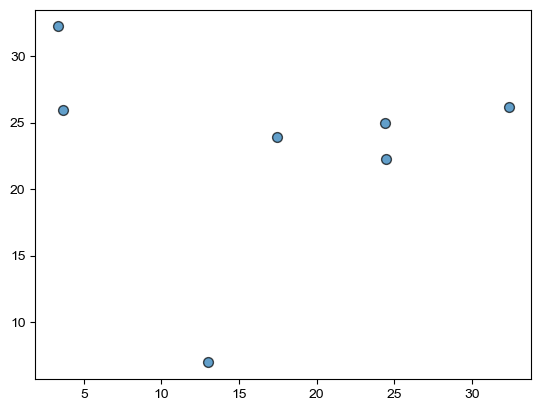

In [128]:
plt.scatter(df_fitted_params.snips_x0,
            df_fitted_params.vel_x0,
            # c=snips_k,
            cmap=custom_cmap, s=50, edgecolor='k', alpha=0.7)

In [48]:
snips_x0

array([ 24.58452062,  26.11179732,   3.1119352 ,  24.53501528,
       -67.36334028, 204.19263553,  12.99085046,   5.47473716,
        17.19499334,  37.28170812])

In [49]:
x_id = []
aucs_id = []
aucs_vel_id = []

for i, id in enumerate(df2_dep_45.id.unique()):
    transition = snips_x0[i]

    if np.isnan(transition) == True or transition < 0 or transition > 50:
        continue

    transition = int(transition)
    tmp = df2_dep_45.query("id == @id")
    print(len(tmp))

    x_id.append(tmp.trial.values - transition)
    aucs_id.append(tmp.auc_snips.values)
    aucs_vel_id.append(tmp.auc_vel.values)

    

    

49
49
49
49
49
49
49
49


In [72]:
df_realigned = pd.DataFrame({
    "trial": np.concatenate(x_id),
    # "auc_snips": np.concatenate(aucs_id),
    "auc_vel": np.concatenate(aucs_vel_id)
})

AttributeError: 'DataFrame' object has no attribute 'auc_vel'

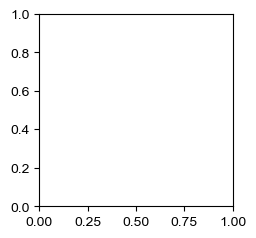

In [85]:
vel_realigned = df_realigned.groupby("trial").mean()
vel_realigned = vel_realigned
f, ax = plt.subplots(figsize=(2.5, 2.5))
ax.bar(1, np.nanmean(vel_realigned.query("trial < 0").auc_vel.values))
ax.bar(2, np.nanmean(vel_realigned.query("trial > 0").auc_vel.values))

<BarContainer object of 1 artists>

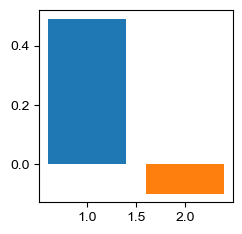

In [ ]:
df_realigned = pd.DataFrame({
    "trial": np.concatenate(x_id),
    "auc_snips": np.concatenate(aucs_id),
    # "auc_vel": np.concatenate(aucs_vel_id)
})

vel_realigned = df_realigned.groupby("trial").mean()
vel_realigned = vel_realigned
f, ax = plt.subplots(figsize=(2.5, 2.5))
ax.bar(1, np.nanmean(vel_realigned.query("trial < 0").auc_snips.values))
ax.bar(2, np.nanmean(vel_realigned.query("trial > 0").auc_snips.values))

In [83]:
vel_realigned

,auc_snips
trial,
-37,0.174369
-36,-0.524988
-35,1.003740
-34,1.163543
-33,0.021211
...,...
41,0.071059
42,0.270399
43,-0.052242


In [84]:
def compare_before_and_after(df):
    
    deltas = []
    for i in range(1, 48):
        before_mean = df[:i].mean()
        after_mean = df[i:].mean()
        deltas.append(after_mean - before_mean)

    return deltas

grouped_df = df2_dep_45.groupby("trial").auc_vel.mean()
deltas_snips = compare_before_and_after(grouped_df)

deltas_snips = np.array(deltas_snips)
np.max(np.abs(deltas_snips))

np.float64(2.8775989351009468)

In [81]:
deltas_snips

array([-0.48056607, -0.50738952, -0.5248036 , -0.60649746, -0.62260164,
       -0.63879694, -0.66351659, -0.6632954 , -0.6622368 , -0.66705379,
       -0.67779671, -0.6734443 , -0.67480514, -0.68984988, -0.66957427,
       -0.66356481, -0.65203336, -0.63102063, -0.61975421, -0.60620461,
       -0.60055067, -0.60439877, -0.60416015, -0.5971081 , -0.57495864,
       -0.5812289 , -0.57376823, -0.54611764, -0.54572678, -0.52322516,
       -0.51020636, -0.496671  , -0.47912405, -0.45157837, -0.44381748,
       -0.41590554, -0.39958609, -0.39034211, -0.3914898 , -0.40514259,
       -0.38790321, -0.37688056, -0.34598162, -0.37529112, -0.35614977,
       -0.30435485, -0.35079944])

In [66]:
np.nanmean(vel_realigned.auc_vel.iloc[:0].values)

C:\Users\jmc010\AppData\Local\Temp\ipykernel_28156\2729894015.py:1: RuntimeWarning: Mean of empty slice
  np.nanmean(vel_realigned.auc_vel.iloc[:0].values)


np.float64(nan)

<Axes: xlabel='trial'>

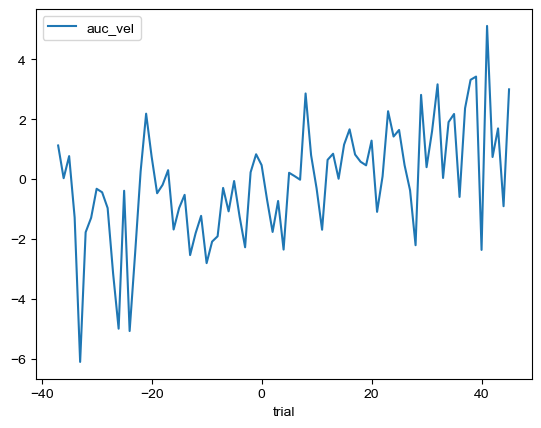

In [57]:
df_realigned.groupby("trial").mean().plot()

<Axes: xlabel='trial'>

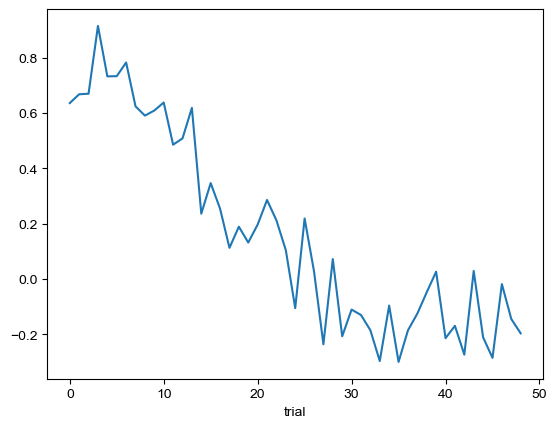

In [45]:
df2_dep_45.groupby("trial").auc_snips.mean().plot()

In [ ]:
popt, pcov = curve_fit(sigmoid, x, y, p0=[max(y), np.median(x), 1, min(y)])

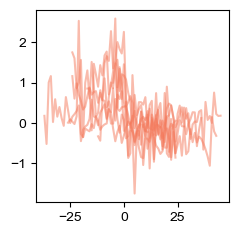

In [ ]:
realigned_aucs = []

f, ax = plt.subplots(figsize=(2.5, 2.5))
for i, x in enumerate(x_id):
    y = aucs_id[i]
    ax.plot(x, y, color=colors[2], alpha=0.5)
    

